# experiments

In [1]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import rbf_kernel
from itertools import product
import matplotlib.pyplot as plt

In [2]:
def evaluate_model(y_train,y_train_mod, y_mod_pred):
	print("Number of label changes made in dataset:",np.count_nonzero(y_train - y_train_mod))
	print("Model Accuracy w.r.t. Original dataset:",np.count_nonzero((y_train - y_mod_pred)==0)*100.0/y_train.shape[0])
	print("Model Accuracy w.r.t. Modified dataset:\n",
          np.count_nonzero((y_train_mod - y_mod_pred)==0)*100.0/y_train.shape[0])

In [3]:
def check_trusted_items(X_train,y_train,X_trust,y_trust, sigma, lam, combo=None, 
						train_cluster_labels=None, trust_cluster_labels=None, plot=False):
	clf = LogisticRegression(solver='lbfgs', C=lam)
	K = rbf_kernel(X_train, X_train, gamma=(-1/(2.0*sigma**2)))
	clf.fit(K, y_train)
	y_train_pred = clf.predict(K)

	K_trust = rbf_kernel(X_trust, X_train, gamma=(-1/(2.0*sigma**2)))
	y_trust_pred = clf.predict(K_trust)

	if np.array_equal(y_trust, y_trust_pred):
		print("All trusted items predicted correctly by model")
		plot_model(X_train, y_train, clf, sigma, X_trust, y_trust, str(combo)+" Good", 
													train_cluster_labels, trust_cluster_labels)
		check = True
	else:
		print("Some trusted items were incorrectly predicted. Continuing experiment...")
		if plot:
			plot_model(X_train, y_train, clf, sigma, X_trust, y_trust, str(combo)+" Bad", 
		 											train_cluster_labels, trust_cluster_labels)
		check = False
	return clf, y_train_pred, y_trust_pred, check

In [4]:
def modify_labels(K, y_train, train_cluster_labels, combo, max_changes=np.inf):
	
	y_train_mod = np.copy(y_train)
	for i in range(K):
		y_train_mod[train_cluster_labels==i] = combo[i]
	
	num_changes = np.count_nonzero(y_train - y_train_mod)
	if num_changes>max_changes:
		# print("Too many changes to dataset:",num_changes,"\n")
		return None
	else:
		return y_train_mod


In [5]:
def cluster_data(X_train, y_train, X_trust, y_trust, sigma, lam, try_all_combos=False):
	
	label_set = list(set(y_train))

	# Visualize original dataset
	print("Running Kernel Logistic Regression without any modifications to dataset...")

	clf, y_pred, y_trust_pred, check = check_trusted_items(X_train,y_train,X_trust,y_trust, sigma, lam, plot=True)
	evaluate_model(y_train,y_train, y_pred)

	if check:
		print("All trusted items classified correctly using original dataset! \n")
		return

	print
	# try_all_combos = True

	min_K = 5
	max_K = 10
	if try_all_combos:
		print("Trying all labeling of clusters, from K =%d to %d\n"%(min_K,max_K))
	else:
		print("Modifying only labels of clusters containing mislabeled trusted items, from K =%d to %d\n"%(min_K,max_K))

	for K in range(min_K,max_K+1):
		kmeans = KMeans(n_clusters=K)
		kmeans.fit(X_train)

		train_cluster_labels = kmeans.labels_
		trust_cluster_labels = kmeans.predict(X_trust)

		if try_all_combos:
			all_combos = list(product(label_set, repeat=K)) 
			# this list contains every possible combination of labels for each cluster
			
			for combo in all_combos:
				if len(set(combo))<=1:
					continue

				y_train_mod = modify_labels(K, y_train, train_cluster_labels, combo, max_changes=20)
				if y_train_mod is None:
					continue

				print(combo,":",)

				clf, y_mod_pred, _, check = check_trusted_items(X_train,y_train_mod,X_trust,y_trust, sigma, lam, combo, 
																train_cluster_labels, trust_cluster_labels)
				
				evaluate_model(y_train,y_train_mod, y_mod_pred)
		else:
			y_train_mod = np.copy(y_train)
			print("Trusted Clustering for K=%d"%K)
			for i in range(len(y_trust_pred)):
				if y_trust_pred[i]!=y_trust[i]:
					y_train_mod[train_cluster_labels==trust_cluster_labels[i]] = y_trust[i]

			# print(y_trust_pred,y_trust)
			# print(y_train)
			# print(y_train_mod)
			# print(train_cluster_labels,trust_cluster_labels)


			clf, y_mod_pred, _, check = check_trusted_items(X_train,y_train_mod,X_trust,y_trust, sigma, lam, "Trusted clustering: %d"%K, 
															train_cluster_labels, trust_cluster_labels, plot=True)
			
			evaluate_model(y_train,y_train_mod, y_mod_pred)

	plt.show()

# plotting

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import rbf_kernel

In [7]:
# ----------------------------------------
# For plotting data and decision boundary
def plot_model(X_train, y_train, clf, sigma, X_trust=None, y_trust=None, title=None, 
													train_cluster_labels=None, trust_cluster_labels=None):

	X = np.zeros((10000,2))
	a = np.linspace(0,1,100)
	b = np.linspace(0,1,100)
	e, d = np.meshgrid(a, b)
	X[:,0] = np.reshape(e,(10000,))
	X[:,1] = np.reshape(d,(10000,))

	K = rbf_kernel(X, X_train, gamma=(-1/(2.0*sigma**2)))
	Z = clf.predict(K)
	probs = clf.predict_proba(K)[:, 1].reshape(e.shape)

	plt.figure()

	# Put the result into a color plot
	Z = Z.reshape(e.shape)
	plt.contour(e, d, probs, levels=[0.5])

	# Plot clusters
	if train_cluster_labels is not None:
		if trust_cluster_labels is not None:
			cluster_labels = np.concatenate([train_cluster_labels,trust_cluster_labels])
			X = np.vstack([X_train, X_trust])
			plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, marker='o', s=80)
		else:
			plt.scatter(X_train[:, 0], X_train[:, 1], c=train_cluster_labels, marker='o', s=80)

	# Plot the training points
	plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, marker='.')
	
	# Plot the trusted points
	if X_trust is not None:
		plt.scatter(X_trust[:, 0], X_trust[:, 1], c=y_trust, cmap=plt.cm.Paired, marker='X')

	if title is not None:
		plt.title(str(title))

	plt.xlabel('Magical Heritage')
	plt.ylabel('Education')
	plt.xlim(0, 1)
	plt.ylim(0, 1)
	plt.draw()

# HarryPotter

In [8]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import rbf_kernel

In [9]:
# for reproducibility, fix the random seed 
np.random.seed(123)

# the learner is hard coded to be kernel logistic regression.
# learner's parameters:
lam = 1e-3	# L2 regularization weight of learner
sigma = 0.4	# RBF kernel bandwidth

In [10]:
################### Harry Potter Toy Example ##################

# ----------------------------------------
# Generate "dirty" training data. 
# that is, we will plant some "historical bias" 
# in the form of labels: the Ministry of Magic refused to hire
# muggle-born graduates with high edcuation.

print("Creating training data...\n")

# Training Set size
n = 100 

# data points are on a uniform grid, then dithered with a Gaussian.
# x_1=magic heritage; x_2=education

X_train = np.zeros((n,2))
a = np.linspace(0.05, 0.95, num=int(np.sqrt(n)))
e, d = np.meshgrid(a, a)
X_train[:,0] = np.reshape(e,(n,))
X_train[:,1] = np.reshape(d,(n,))
X_train = X_train + 0.03*np.random.rand(n,2)
# print(X_train)

# the noiseless 'desired' label obeys y = sign(x_2 - 0.5)
y_clean = np.sign(X_train[:,1]-0.5)
# print(y_clean)

y_train = np.copy(y_clean)
y_train[(X_train[:,1]<(4*(X_train[:,0]-0.5)**2+0.5)) & (X_train[:,0]<0.5)] = -1
# print(y_train-y_clean)

Creating training data...



In [11]:
# --------------------------------------------------------------
# Generate trusted data
# we manually picked these two trusted items for pedagogical purpose
print("Creating trusted data...\n")

X_trust = np.array([[0.3, 0.4],[0.2, 0.6]])
y_trust = np.sign(X_trust[:,1]-0.5)
m = y_trust.shape[0]
c_value = 100  # Confidence parameters on trusted items are set to 100.
c = c_value*np.ones((m,1))

Creating trusted data...



Running Kernel Logistic Regression without any modifications to dataset...
Some trusted items were incorrectly predicted. Continuing experiment...
Number of label changes made in dataset: 0
Model Accuracy w.r.t. Original dataset: 97.0
Model Accuracy w.r.t. Modified dataset:
 97.0
Modifying only labels of clusters containing mislabeled trusted items, from K =5 to 10

Trusted Clustering for K=5
All trusted items predicted correctly by model
Number of label changes made in dataset: 11
Model Accuracy w.r.t. Original dataset: 89.0
Model Accuracy w.r.t. Modified dataset:
 100.0
Trusted Clustering for K=6
Some trusted items were incorrectly predicted. Continuing experiment...
Number of label changes made in dataset: 12
Model Accuracy w.r.t. Original dataset: 82.0
Model Accuracy w.r.t. Modified dataset:
 88.0
Trusted Clustering for K=7
All trusted items predicted correctly by model
Number of label changes made in dataset: 13
Model Accuracy w.r.t. Original dataset: 86.0
Model Accuracy w.r.t. Mo

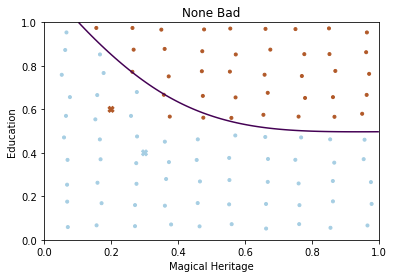

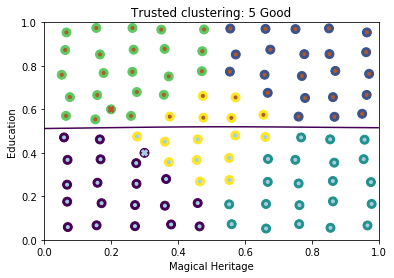

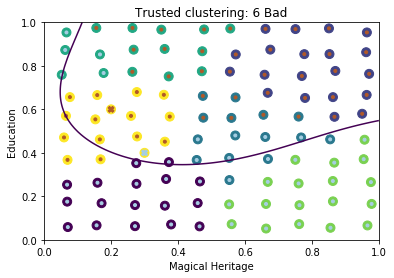

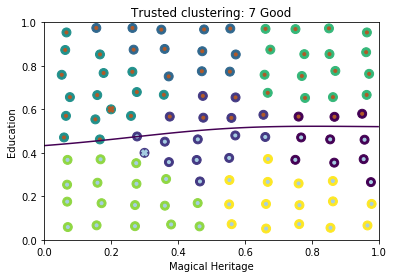

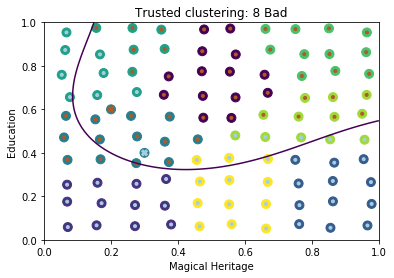

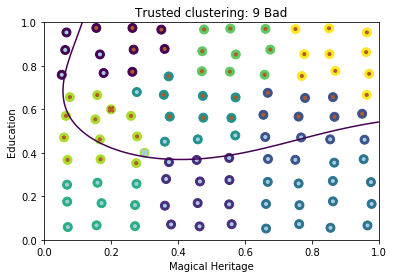

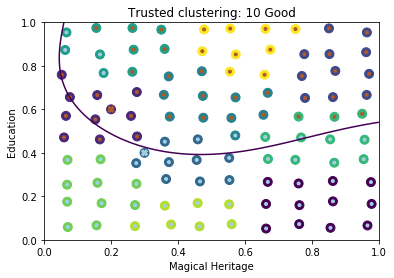

In [12]:
# --------------------------------------------------------------
# Experimenting with clustering
cluster_data(X_train, y_train, X_trust, y_trust, sigma, lam)